# Multitask error vs correct classification


In [17]:
%pip install mne
%pip install openneuro-py
%pip install mne-bids
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 1.1 MB/s eta 0:00:0000:0100:01m
Using cached threadpoolctl-3.6.0-py3-none-any.whl (18 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [scikit-learn] [scikit-learn]
Note: you may need to restart the kernel to use updated packages.


In [1]:
# you have to install openneuro-py and mne-bids packages
# if using colab, run:
# !pip install openneuro-py
# !pip install mne-bids
# if working locally, install modlules using pip

import os
import os.path as op
import openneuro

from mne.datasets import sample
from mne_bids import (
    BIDSPath,
    read_raw_bids,
    print_dir_tree,
    make_report,
    find_matching_paths,
    get_entity_vals,
)
import mne

import numpy as np

/Users/procyon/eeg-proj/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Download dataset

In [2]:
dataset = "ds004883"

# number of participants to fetch
n = 30
subjects = [f'sub-{subject:03}' for subject in range(1, n+1)]

# Download one subject's data from each dataset
bids_root = "E:\mne_data\ds004883"

In [ ]:
if not op.isdir(bids_root):
    os.makedirs(bids_root)

# this download full dataset, it might took few hours
openneuro.download(dataset=dataset, target_dir=bids_root, include=subjects)

## 2. Read data and create epochs

In [4]:
def read_flanker_data(
    participants_num=10,
    bids_root=bids_root,
    save=False
    ):
    datatype = "eeg"
    bids_path = BIDSPath(root=bids_root, datatype=datatype)

    tasks = [
    "ffa",
    "ffb",
    'ffc'
    ]
    subjects = [f'{subject:03}' for subject in range(1, participants_num+1)]
    suffix = "eeg"

    # define montage to be set
    montage = mne.channels.make_standard_montage('GSN-HydroCel-129')

    eeg_data = {}
    for task in tasks:
        for subject_id in subjects:
            # extract subject and task specific path to data
            bids_path = bids_path.update(subject=subject_id, task=task, suffix=suffix)

            # create raw
            this_raw = read_raw_bids(bids_path=bids_path, verbose=False, extra_params={'preload':True})

            ################################
            ### Basic preprocessing
            ################################

            # set montage
            this_raw.set_montage(montage)

            # filter data
            raw_filtered = this_raw.copy().filter(
                l_freq=.1,
                h_freq=30.0,
                n_jobs=10,
                method='iir',
                iir_params=None,
            )

            # Notch filter at 60 Hz
            raw_filtered = raw_filtered.notch_filter(
                freqs=np.arange(60, (raw_filtered.info['sfreq'] / 2), 60),
                n_jobs=10,
            )

            # create events
            events, events_ids = mne.events_from_annotations(raw_filtered)

            # create epochs
            epochs = mne.Epochs(
                raw_filtered,
                tmin=-0.2,
                tmax=0.8,
                events=events,
                event_id= {'cor': 2, 'err': 3},
                baseline=(-0.2, 0)
            )

            ################################
            ### Optionally you can save individual's epochs
            ################################
            if save:
              output_dir = os.path.join('epochs', task)
              os.makedirs(output_dir, exist_ok=True)

              # Define output filename
              output_fname = os.path.join(output_dir, f"{subject_id}-epo.fif")

              # Save the epochs
              epochs.save(output_fname, overwrite=True)

            ################################
            ### Add epochs to dict
            ################################

            if task in eeg_data.keys():
                eeg_data[task].append(epochs)
            else:
                eeg_data[task] = [epochs]
    return eeg_data

In [3]:
data = read_flanker_data(participants_num=n, bids_root=bids_root, save=True)

NameError: name 'read_flanker_data' is not defined

In [5]:
bids_root = "E:\mne_data\ds004883"

<>:1: SyntaxWarning: invalid escape sequence '\m'
<>:1: SyntaxWarning: invalid escape sequence '\m'
C:\Users\48506\AppData\Local\Temp\ipykernel_16408\117217165.py:1: SyntaxWarning: invalid escape sequence '\m'
  bids_root = "E:\mne_data\ds004883"


In [4]:
import mne
import os

def load_fif():
    return {
        task: [mne.read_epochs(os.path.join('epochs', task, fif)) for fif in sorted(os.listdir(os.path.join('epochs', task)))]
        for task in os.listdir('epochs')
    }

In [6]:
data = load_fif()

Reading /Users/procyon/eeg-proj/epochs/ffc/001-epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     800.00 ms
        0 CTF compensation matrices available
Not setting metadata
397 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/procyon/eeg-proj/epochs/ffc/002-epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     800.00 ms
        0 CTF compensation matrices available
Not setting metadata
399 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/procyon/eeg-proj/epochs/ffc/003-epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     800.00 ms
        0 CTF compensation matrices available
Not setting metadata
389 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/procyon/eeg-proj/epochs/ffc/004-epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     800.00 ms
        0 CTF

In [7]:
from sklearn.model_selection import train_test_split

split = train_test_split(*data.values(), test_size=0.3)
P_train = split[0] + split[2] + split[4]
P_test = split[1] + split[3] + split[5]
print('train size', len(P_train))
print('test size', len(P_test))

train size 63
test size 27


In [ ]:
# Tego nie trzeba odpalac chyba ze sie chce obrazki itd
epochs_train = mne.concatenate_epochs(P_train) # Ok. 3-5 minut

C:\Users\48506\AppData\Local\Temp\ipykernel_10364\598781154.py:1: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs_train = mne.concatenate_epochs(P_train) # Ok. 3-5 minut


Not setting metadata
33791 matching events found
Applying baseline correction (mode: mean)


combining channels using GFP (eeg channels)
combining channels using GFP (eeg channels)


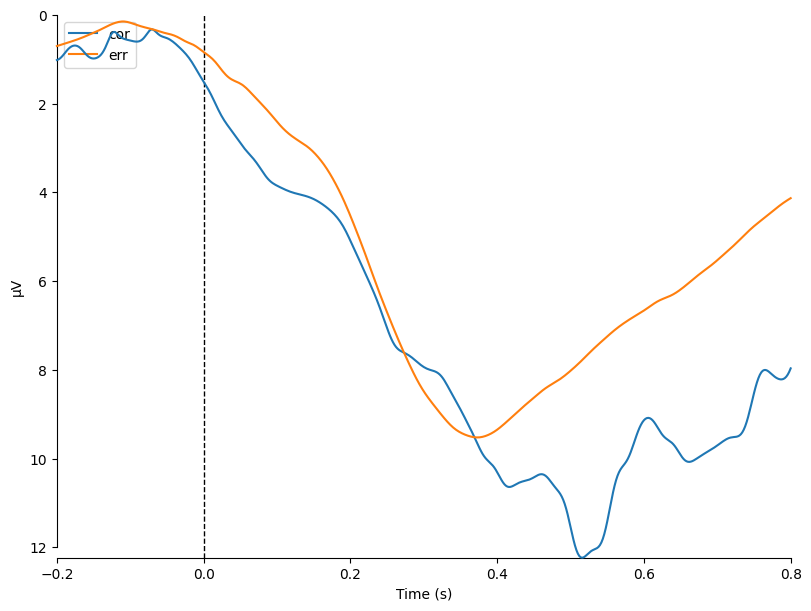

In [ ]:
# Obrazek. Mozna tego nie odpalac. Jakies 35 minut się liczy. Nie warto.

picks = 'data' # Lista elektrod lub data
fig = mne.viz.plot_compare_evokeds(
    evokeds = {'cor': epochs_train['cor'].average(), 'err': epochs_train['err'].average()},
    picks=picks,
    invert_y=True
)

In [ ]:
# Proba znalezienia dobrej elektrody wrozebnej 🧙
# Mozna tego nie odpalac.

import numpy as np
from sklearn.discriminant_analysis import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.pipeline import make_pipeline

res = {}
for ch in epochs_train.ch_names:
    cor_data = epochs_train.get_data(picks=[ch], item='cor')
    err_data = epochs_train.get_data(picks=[ch], item='err')

    idx = np.random.randint(cor_data.shape[0], size=err_data.shape[0])
    cor_data = cor_data[idx,:,:]  # Wyrownanie liczebnosci klas

    X_train = np.concatenate((np.mean(cor_data, axis=(1,2)), np.mean(err_data, axis=(1,2)))).reshape(-1, 1)
    y_train = np.concatenate((np.repeat(2, cor_data.shape[0]), np.repeat(3, err_data.shape[0])))

    clf = make_pipeline(
        StandardScaler(),
        LogisticRegression()
    ).fit(X_train, y_train)

    y_pred = clf.predict(X_train)
    res[ch] = accuracy_score(y_true=y_train, y_pred=y_pred)
    print(ch, res[ch])
    

print('Max', max(res, key=res.get))

E1 0.46898334290637567
E2 0.47759908098793796
E3 0.4997128087306146
E4 0.48219414129810456
E5 0.46639862148190697
E6 0.4373923032739805
E7 0.5445146467547387
E8 0.49425617461229177
E9 0.4956921309592188
E10 0.4758759333716255
E11 0.46869615163699024
E12 0.4646754738655945
E13 0.47472716829408385
E14 0.4865020103388857
E15 0.4865020103388857
E16 0.483917288914417
E17 0.47731188971855254
E18 0.4816197587593337
E19 0.48736358414704195
E20 0.5393452039058013
E21 0.4842044801838024
E22 0.49339460080413555
E23 0.49310740953475013
E24 0.4701321079839173
E25 0.5005743825387708
E26 0.5175186674325101
E27 0.5330269959793222
E28 0.4813325674899483
E29 0.4865020103388857
E30 0.4764503159103963
E31 0.5080413555427915
E32 0.4732912119471568
E33 0.5479609419873636
E34 0.5499712808730615
E35 0.4770246984491672
E36 0.4919586444572085
E37 0.5192418150488225
E38 0.5649052268811028
E39 0.539919586444572
E40 0.46352670878805285
E41 0.4784606547960942
E42 0.4971280873061459
E43 0.5479609419873636
E44 0.5496

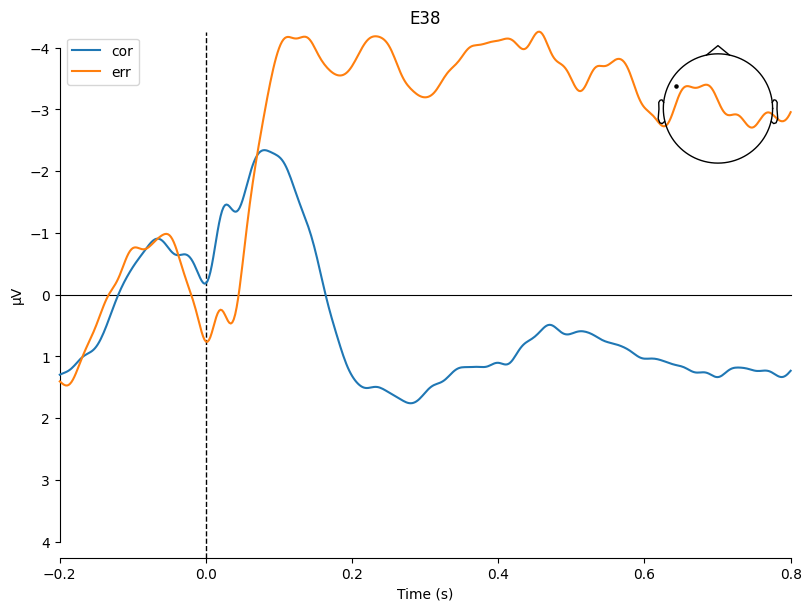

In [ ]:
# Obrazek. Mozna tego nie odpalac.

picks = ['E38'] 
fig = mne.viz.plot_compare_evokeds(
    evokeds = {'cor': epochs_train['cor'].average(), 'err': epochs_train['err'].average()},
    picks=picks,
    invert_y=True
)


In [8]:
from typing import List


def prepare_X_y(epochs: List[mne.Epochs], tmin=-0.2, tmax=0.8, picks='all'):
    cor_datas, err_datas = [], []
    print('get data')
    for e in epochs:
        cor_datas.append(e.get_data(picks=picks, item='cor', tmin=tmin, tmax=tmax))
        err_datas.append(e.get_data(picks=picks, item='err', tmin=tmin, tmax=tmax))

    print('concat cor')
    cor_data = np.concatenate(cor_datas)
    print('concat err')
    err_data = np.concatenate(err_datas)

    print('balancing')
    idx = np.random.randint(cor_data.shape[0], size=err_data.shape[0])
    cor_data = cor_data[idx,:,:]  # Wyrownanie liczebnosci klas

    print('concat X')
    X = np.concatenate((cor_data, err_data))
    # X = np.mean(X, axis=2)
    # X = X.reshape(X.shape[0], -1)
    print('concat y')
    y = np.concatenate((np.repeat(0, cor_data.shape[0]), np.repeat(1, err_data.shape[0])))

    print('shuffle')
    p = np.random.permutation(X.shape[0])
    return X[p], y[p]

# ref https://modma.lzu.edu.cn/static/references/128%20channel%20HydroCel%20Geodesic%20Sensor%20Net-DOT%20probe%20EEG.pdf
# picks = [
#     'E11', # Fz
#     'E55', # Cz 
#     'E62', # Pz  
#     'E75' # Oz
# ]
picks = 'data' # 'data' means all electrodes - takes about 10 min

X, y = prepare_X_y(P_train, picks=picks, tmin=0.0, tmax=0.8)
print(X.shape)


get data
concat cor
concat err
balancing
concat X
concat y
shuffle
(10890, 128, 400)


In [10]:
from sklearn.calibration import LinearSVC
from mne.decoding import LinearModel, Vectorizer
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, StandardScaler
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.kernel_approximation import Nystroem, RBFSampler
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC

print('Split')
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2)

print('Fit')
clf = make_pipeline(
    Vectorizer(),
    StandardScaler(),
    # ExtraTreesClassifier(n_estimators=1024, bootstrap=True, max_samples=0.03),
    # RandomForestClassifier(n_estimators=512, max_depth=16)
    Nystroem(n_components=128), # Nystroem + LinearSVC poleca dokumentacja zamiast SVC kiedy dużo danych
    # PCA(n_components=100), # PCA as alternative to Nystroem here
    LinearModel(
        LinearSVC(C=10),
        # LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.2)
        # LogisticRegression(solver='liblinear')
        # LinearDiscriminantAnalysis() 
        # SGDClassifier(max_iter=64)
    )
).fit(X_train, y_train)

print('Predict train')
y_pred_train = clf.predict(X_train)
print(classification_report(y_train, y_pred_train))

print('Predict validation')
y_pred_validation = clf.predict(X_validation)
print(classification_report(y_validation, y_pred_validation))

Split
Fit
Predict train
              precision    recall  f1-score   support

           0       0.69      0.73      0.71      4345
           1       0.71      0.67      0.69      4367

    accuracy                           0.70      8712
   macro avg       0.70      0.70      0.70      8712
weighted avg       0.70      0.70      0.70      8712

Predict validation
              precision    recall  f1-score   support

           0       0.67      0.69      0.68      1100
           1       0.68      0.65      0.66      1078

    accuracy                           0.67      2178
   macro avg       0.67      0.67      0.67      2178
weighted avg       0.67      0.67      0.67      2178



In [16]:
#baseline CV- uwaga długo się mieli

from sklearn.model_selection import StratifiedKFold, cross_val_score

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(clf, X, y, cv=cv, scoring='accuracy')
print(f"Baseline CV Accuracy: {np.mean(scores):.3f} ± {np.std(scores):.3f}")

Baseline CV Accuracy: 0.680 ± 0.013


In [ ]:
#grid search z cv bc we're crazy like that

from sklearn.model_selection import GridSearchCV, StratifiedKFold

param_grid = dict(linearmodel__model__C = [0.00001, 0.001, 1, 100, 100000], # nie wiem, to jest dużo ale już nie wiem atp
                  nystroem__kernel = ['linear', 'rbf', 'poly', 'sigmoid']
                  )

grid_search = GridSearchCV(
    clf,
    param_grid,
    cv=StratifiedKFold(5, shuffle=True, random_state=42),
    scoring='accuracy',
    n_jobs=1,
    verbose=3,
)

grid_search.fit(X, y)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END linearmodel__model__C=1e-05, nystroem__kernel=linear;, score=0.682 total time=  12.8s
[CV 2/5] END linearmodel__model__C=1e-05, nystroem__kernel=linear;, score=0.658 total time=  12.6s
[CV 3/5] END linearmodel__model__C=1e-05, nystroem__kernel=linear;, score=0.678 total time=  12.5s
[CV 4/5] END linearmodel__model__C=1e-05, nystroem__kernel=linear;, score=0.669 total time=  12.4s
[CV 5/5] END linearmodel__model__C=1e-05, nystroem__kernel=linear;, score=0.669 total time=  12.4s
[CV 1/5] END linearmodel__model__C=1e-05, nystroem__kernel=rbf;, score=0.628 total time=  12.9s
[CV 2/5] END linearmodel__model__C=1e-05, nystroem__kernel=rbf;, score=0.623 total time=  15.2s
[CV 3/5] END linearmodel__model__C=1e-05, nystroem__kernel=rbf;, score=0.618 total time=  14.4s
[CV 4/5] END linearmodel__model__C=1e-05, nystroem__kernel=rbf;, score=0.629 total time=  12.2s


In [ ]:
print('Predict train')
y_pred_train = clf.predict(X_train)
print(classification_report(y_train, y_pred_train))

print('Predict validation')
y_pred_validation = clf.predict(X_validation)
print(classification_report(y_validation, y_pred_validation))

In [45]:
# True test na danych niewykorzystanych do wyboru modelu
# Przygotowanie danych ok. 1 min
# Trzeba tylko odpalać jeśli się zmieniło picks

X_test, y_test = prepare_X_y(P_test, picks=picks, tmin=0.0, tmax=0.8)
print(X_test.shape)

get data
concat cor
concat err
balancing
concat X
concat y
(4708, 128, 400)


In [53]:
clf = clf.fit(X, y) # Uczenie na całym zbiorze treningowym
y_pred_test = clf.predict(X_test)
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.69      0.61      0.65      2354
           1       0.65      0.72      0.69      2354

    accuracy                           0.67      4708
   macro avg       0.67      0.67      0.67      4708
weighted avg       0.67      0.67      0.67      4708

